# 02 - Temel Görselleştirmeler

Bu dosya, 2025 Yazilim Sektoru Maas Anketi analizi icin temel gorsellestirmeleri olusturur.

## Hedefler:
- Anahtar degiskenlere gore maas dagilimlari için box plot olusturmak
- Rol tabanlı maaş analizi için bar plot olusturmak
- Kariyer zaman çizelgesi analizi için scatter plots olusturmak
- Cinsiyete dayali teknoloji kullanimi gorsellestirmeleri olusturmak    

## Kütüphaneleri İçe Aktarın ve Verileri Yükleyin

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set up plotting style
sns.set_palette("husl")
plt.rcParams['font.family'] = 'DejaVu Sans'
# sns.set_style("whitegrid")

# Constants
FIG_DIR = '../figures'
LOCATION_NOTE = 'Note: Estimated location is inferred from company location and work mode (Office/Hybrid → company location). Not definitive. "Yurtdışı TR hub" responses are excluded from location-based inference.'

# Load processed data
df = pd.read_pickle('../data/processed_dataframe.pkl')
print(f'Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns')

Dataset loaded: 2969 rows, 94 columns


## Boxplots: Maaş Dağılımı Analizi

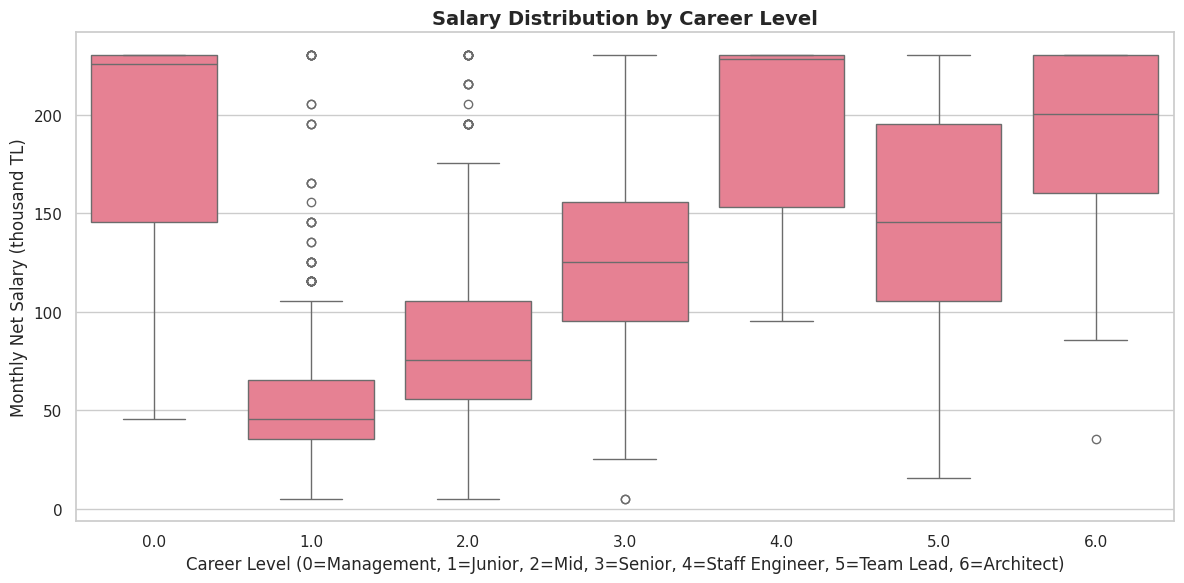

Salary Statistics by Career Level:


,Count,Mean,Std Dev,Min,Max
Management,83,184.8,57.6,45.5,230.5
Junior,733,55.1,33.3,5.0,230.5
Mid,1138,84.1,35.7,5.0,230.5
Senior,772,130.8,47.2,5.0,230.5
Staff Engineer,16,193.0,48.8,95.5,230.5
Team Lead,175,150.5,52.6,15.5,230.5
Architect,52,188.4,48.4,35.5,230.5


In [63]:
# Seniority vs Salary Boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='seniority_level_ic', y='salary_numeric')
plt.title('Salary Distribution by Career Level', fontsize=14, fontweight='bold')
plt.xlabel('Career Level (0=Management, 1=Junior, 2=Mid, 3=Senior, 4=Staff Engineer, 5=Team Lead, 6=Architect)', fontsize=12)
plt.ylabel('Monthly Net Salary (thousand TL)', fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'boxplot_seniority.png'), dpi=300, bbox_inches='tight')
plt.show()

# Display summary statistics
seniority_stats = df.groupby('seniority_level_ic')['salary_numeric'].agg(['count', 'mean', 'std', 'min', 'max']).round(1)
seniority_stats.columns = ['Count', 'Mean', 'Std Dev', 'Min', 'Max']
seniority_stats.index = ['Management', 'Junior', 'Mid', 'Senior', 'Staff Engineer','Team Lead', 'Architect']
print("Salary Statistics by Career Level:")
display(seniority_stats)

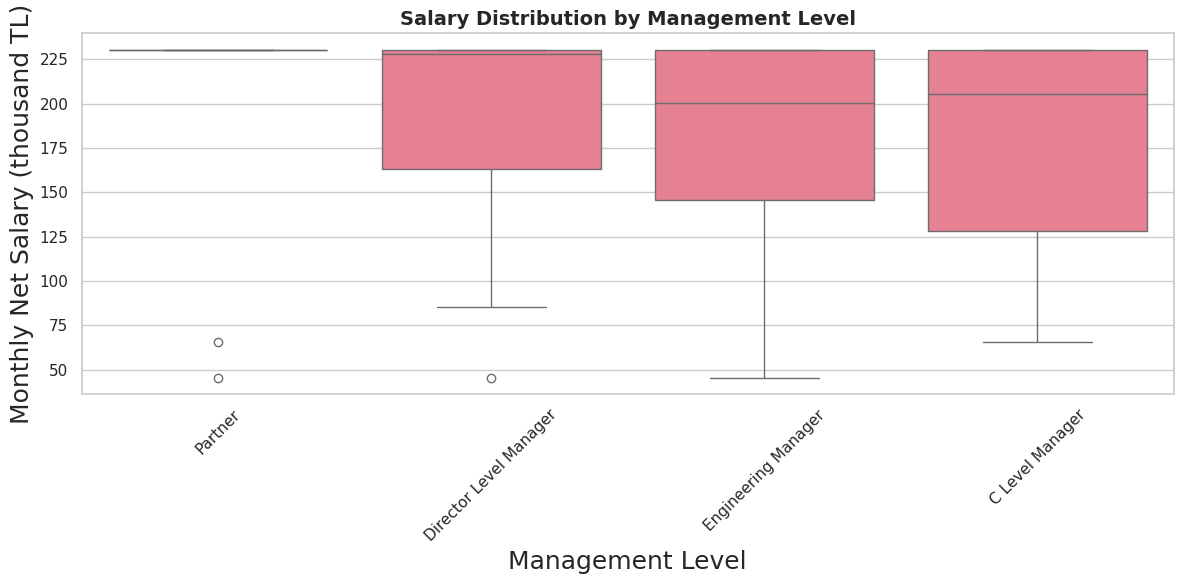

Salary Statistics by Management Level:


,Count,Mean,Std Dev
management_level_label,,,
C Level Manager,18,178.8,56.2
Director Level Manager,24,189.7,55.2
Engineering Manager,30,179.3,56.9
Partner,11,198.7,70.9


In [64]:
# Management Level vs Salary Boxplot
if 'is_manager' in df.columns:
    management_cols = [c for c in df.columns if c.startswith('management_')]
    managers = df[df['is_manager'] == 1].copy()
    
    if not managers.empty and management_cols:
        def get_management_level(row):
            for col in management_cols:
                try:
                    if row[col] == 1:
                        return col.replace('management_', '').replace('_', ' ')
                except KeyError:
                    continue
            return 'Unknown'

        managers['management_level_label'] = managers.apply(get_management_level, axis=1)
        
        if managers['management_level_label'].nunique() > 1 or managers['management_level_label'].iloc[0] != 'Unknown':
            plt.figure(figsize=(12, 6))
            sns.boxplot(data=managers, x='management_level_label', y='salary_numeric')
            plt.title('Salary Distribution by Management Level', fontsize=14, fontweight='bold')
            plt.xlabel('Management Level', fontsize=18)
            plt.ylabel('Monthly Net Salary (thousand TL)', fontsize=18)
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.savefig(os.path.join(FIG_DIR, 'boxplot_management_level.png'), dpi=300, bbox_inches='tight')
            plt.show()
            
            # Display summary statistics
            mgmt_stats = managers.groupby('management_level_label')['salary_numeric'].agg(['count', 'mean', 'std']).round(1)
            mgmt_stats.columns = ['Count', 'Mean', 'Std Dev']
            print("Salary Statistics by Management Level:")
            display(mgmt_stats)

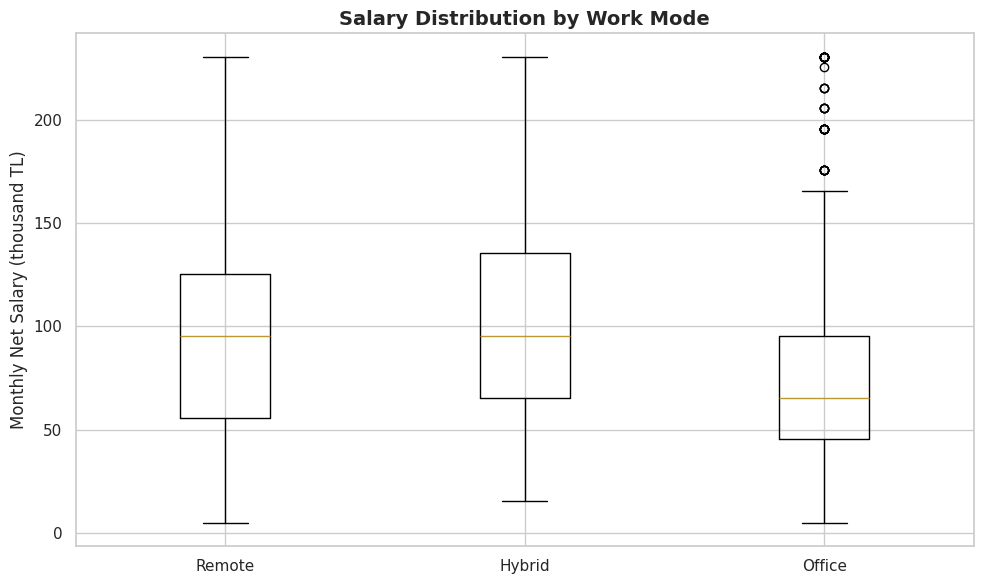

Salary Statistics by Work Mode:


,Work Mode,Count,Mean,Std Dev
0,Remote,1350,101.2,55.8
1,Hybrid,1046,105.0,54.1
2,Office,573,78.6,49.9


In [65]:
# Work Mode vs Salary Boxplot
work_modes = []
work_labels = []
for mode in ['Remote', 'Hybrid', 'Office']:
    col = f'work_mode_{mode}'
    if col in df.columns:
        vals = df.loc[df[col] == 1, 'salary_numeric']
        if len(vals) > 0:
            work_modes.append(vals)
            work_labels.append(mode)

if work_modes:
    plt.figure(figsize=(10, 6))
    plt.boxplot(work_modes, tick_labels=work_labels)
    plt.title('Salary Distribution by Work Mode', fontsize=14, fontweight='bold')
    plt.ylabel('Monthly Net Salary (thousand TL)', fontsize=12)
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, 'boxplot_work_mode.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    # Display summary statistics
    work_mode_data = []
    for i, mode in enumerate(work_labels):
        work_mode_data.append({
            'Work Mode': mode,
            'Count': len(work_modes[i]),
            'Mean': work_modes[i].mean(),
            'Std Dev': work_modes[i].std()
        })
    work_mode_stats = pd.DataFrame(work_mode_data).round(1)
    print("Salary Statistics by Work Mode:")
    display(work_mode_stats)

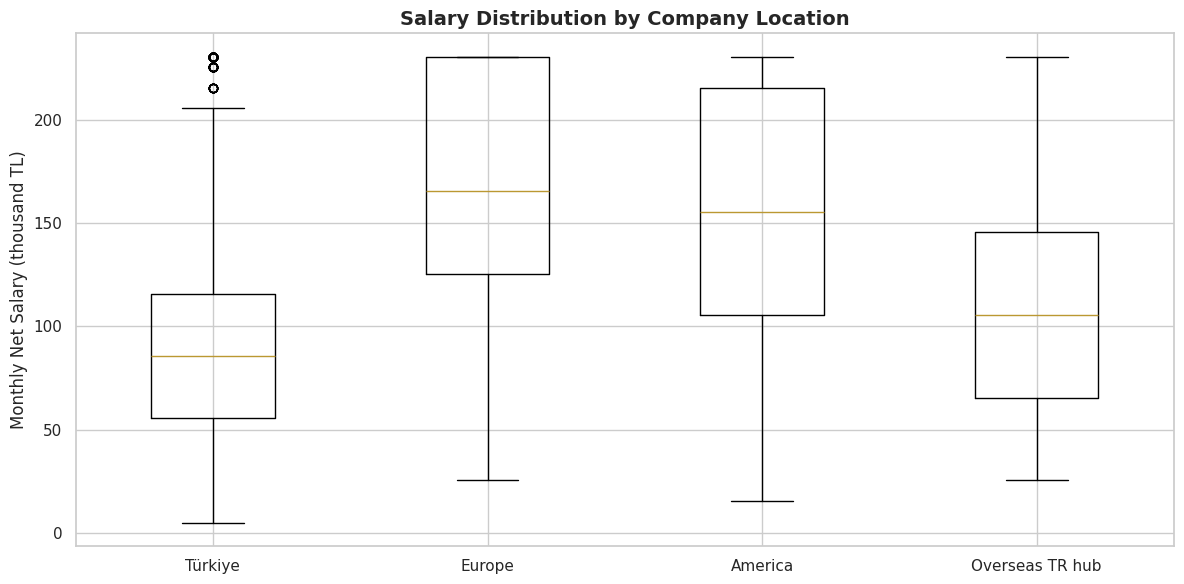

Salary Statistics by Company Location:


,Location,Count,Mean,Std Dev
0,Türkiye,2671,92.9,51.4
1,Europe,132,162.9,59.6
2,America,74,154.4,61.9
3,Overseas TR hub,92,113.2,55.7


In [66]:
# Company Location vs Salary Boxplot
location_label_map = {
    'Turkiye': 'Türkiye',
    'Avrupa': 'Europe',
    'Amerika': 'America',
    'Yurtdisi_TR_hub': 'Overseas TR hub'
}

loc_series = []
loc_labels = []
for loc in ['Turkiye', 'Avrupa', 'Amerika', 'Yurtdisi_TR_hub']:
    col = f'company_location_{loc}'
    if col in df.columns:
        vals = df.loc[df[col] == 1, 'salary_numeric']
        if len(vals) > 0:
            loc_series.append(vals)
            loc_labels.append(location_label_map.get(loc, loc.replace('_', ' ')))

if loc_series:
    plt.figure(figsize=(12, 6))
    plt.boxplot(loc_series, tick_labels=loc_labels)
    plt.title('Salary Distribution by Company Location', fontsize=14, fontweight='bold')
    plt.ylabel('Monthly Net Salary (thousand TL)', fontsize=12)
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, 'boxplot_company_location.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    # Display summary statistics
    location_data = []
    for i, loc in enumerate(loc_labels):
        location_data.append({
            'Location': loc,
            'Count': len(loc_series[i]),
            'Mean': loc_series[i].mean(),
            'Std Dev': loc_series[i].std()
        })
    location_stats = pd.DataFrame(location_data).round(1)
    print("Salary Statistics by Company Location:")
    display(location_stats)

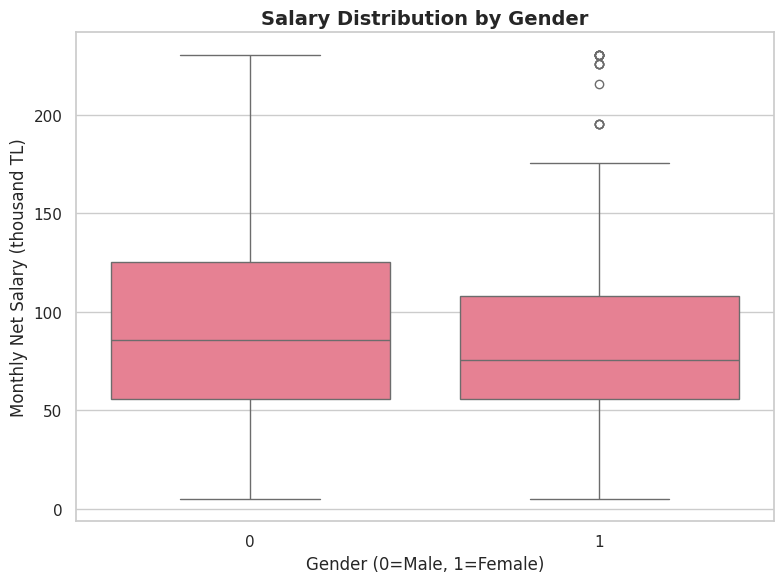

Salary Statistics by Gender:


,Count,Mean,Std Dev
Male,2705,99.4,55.3
Female,264,86.1,49.6


In [ ]:
# Gender vs Salary Boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='gender', y='salary_numeric')
plt.title('Salary Distribution by Gender', fontsize=14, fontweight='bold')
plt.xlabel('Gender (0=Male, 1=Female)', fontsize=12)
plt.ylabel('Monthly Net Salary (thousand TL)', fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'boxplot_gender.png'), dpi=300, bbox_inches='tight')
plt.show()

# Display summary statistics
gender_stats = df.groupby('gender')['salary_numeric'].agg(['count', 'mean', 'std']).round(1)
gender_stats.columns = ['Count', 'Mean', 'Std Dev']
gender_stats.index = ['Male', 'Female']
print("Salary Statistics by Gender:")
display(gender_stats)

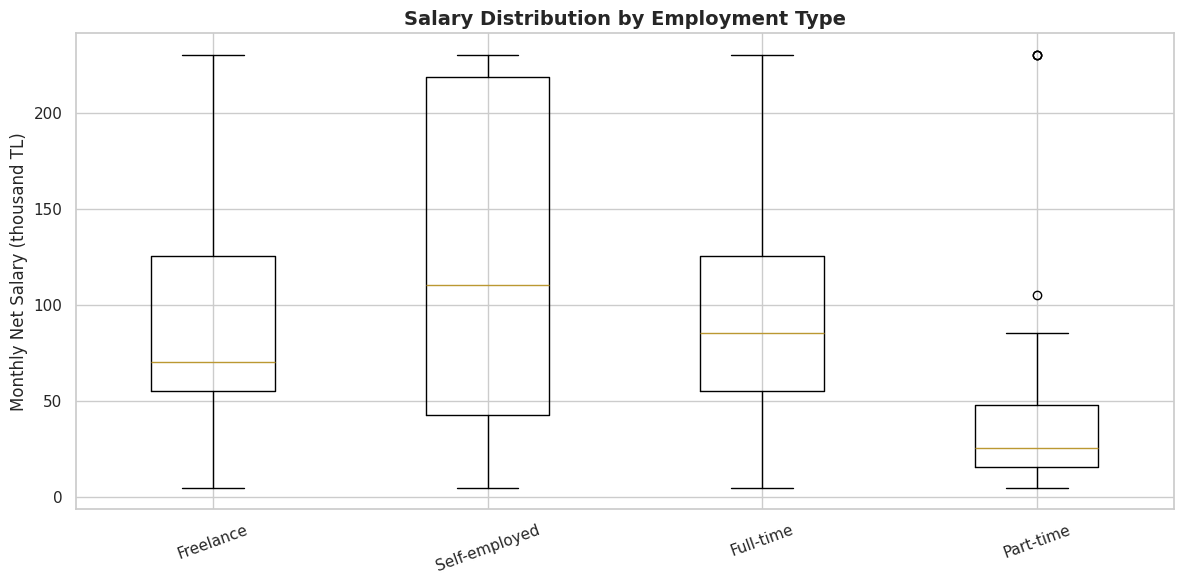

Salary Statistics by Employment Type:


,Employment Type,Count,Mean,Std Dev
0,Freelance,36,94.4,68.0
1,Self-employed,40,123.4,87.7
2,Full-time,2837,99.0,53.7
3,Part-time,56,43.0,50.1


In [68]:
# Employment Type vs Salary Boxplot
employment_label_map = {
    'Freelance': 'Freelance',
    'Kendi_isim': 'Self-employed',
    'Tam_zamanli': 'Full-time',
    'Yari_zamanli': 'Part-time'
}

emp_cols = [c for c in df.columns if c.startswith('employment_type_')]
if emp_cols:
    data = []
    labels = []
    for c in emp_cols:
        vals = df.loc[df[c] == 1, 'salary_numeric']
        if len(vals) > 0:
            data.append(vals)
            raw = c.replace('employment_type_', '')
            labels.append(employment_label_map.get(raw, raw.replace('_', ' ')))
    
    if data:
        plt.figure(figsize=(12, 6))
        plt.boxplot(data, tick_labels=labels)
        plt.title('Salary Distribution by Employment Type', fontsize=14, fontweight='bold')
        plt.ylabel('Monthly Net Salary (thousand TL)', fontsize=12)
        plt.xticks(rotation=20)
        plt.tight_layout()
        plt.savefig(os.path.join(FIG_DIR, 'boxplot_employment_type.png'), dpi=300, bbox_inches='tight')
        plt.show()
        
        # Display summary statistics
        employment_data = []
        for i, label in enumerate(labels):
            employment_data.append({
                'Employment Type': label,
                'Count': len(data[i]),
                'Mean': data[i].mean(),
                'Std Dev': data[i].std()
            })
        employment_stats = pd.DataFrame(employment_data).round(1)
        print("Salary Statistics by Employment Type:")
        display(employment_stats)

## Bar Plots: Rol ve ROI Analizi

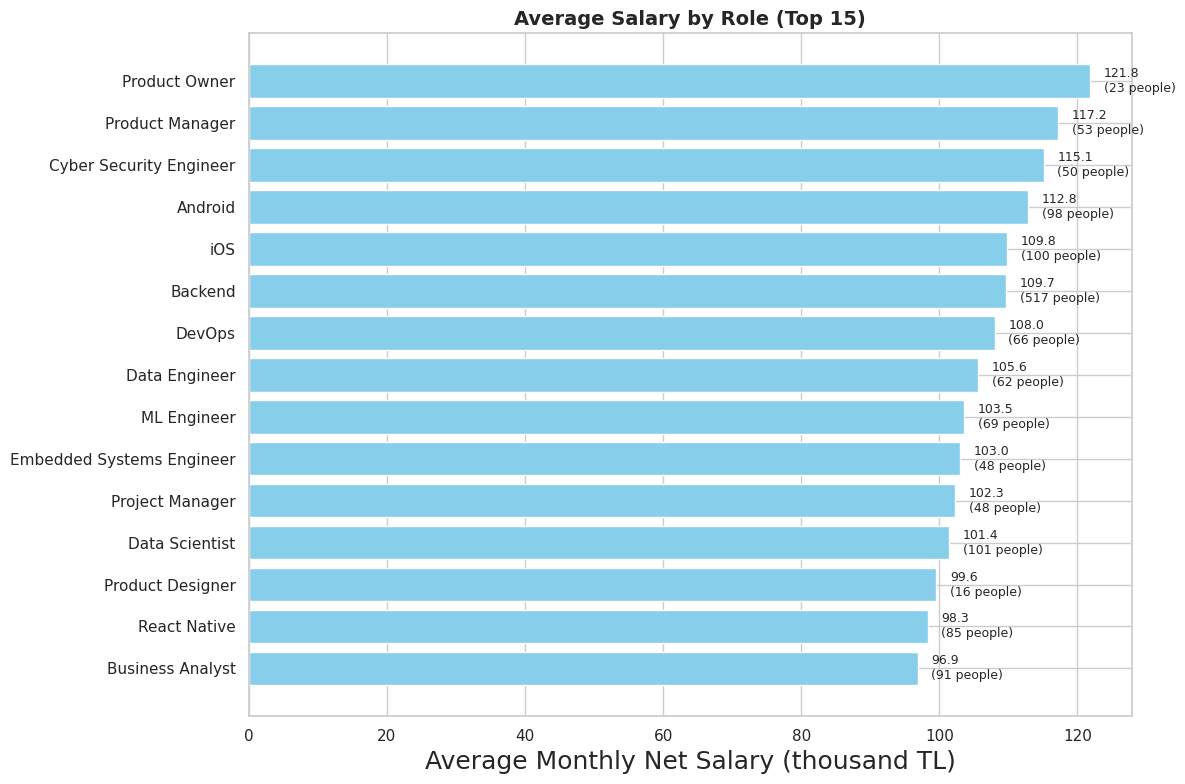

Top 15 Roles by Average Salary (Graph):


,Role,Average Salary,Count
0,Product Owner,121.8,23
1,Product Manager,117.2,53
2,Cyber Security Engineer,115.1,50
3,Android,112.8,98
4,iOS,109.8,100
5,Backend,109.7,517
6,DevOps,108.0,66
7,Data Engineer,105.6,62
8,ML Engineer,103.5,69
9,Embedded Systems Engineer,103.0,48



All Roles by Average Salary:


,Role,Average Salary,Count
0,Product Owner,121.8,23
1,Product Manager,117.2,53
2,Cyber Security Engineer,115.1,50
3,Android,112.8,98
4,iOS,109.8,100
5,Backend,109.7,517
6,DevOps,108.0,66
7,Data Engineer,105.6,62
8,ML Engineer,103.5,69
9,Embedded Systems Engineer,103.0,48


In [72]:
# Role average salaries (top 15)
role_cols = [c for c in df.columns if c.startswith('role_')]
role_stats = []
for c in role_cols:
    role_name = c.replace('role_', '').replace('_', ' ')
    vals = df.loc[df[c] == 1, 'salary_numeric']
    if len(vals) >= 5:
        role_stats.append((role_name, float(vals.mean()), int(len(vals))))

role_stats.sort(key=lambda x: x[1], reverse=True)
if role_stats:
    names, means, counts = zip(*role_stats[:15])
    
    plt.figure(figsize=(12, 8))
    bars = plt.barh(names, means, color='skyblue')
    plt.gca().invert_yaxis()
    plt.title('Average Salary by Role (Top 15)', fontsize=14, fontweight='bold')
    plt.xlabel('Average Monthly Net Salary (thousand TL)', fontsize=18)
    
    for i, (bar, m, n) in enumerate(zip(bars, means, counts)):
        plt.text(m + 2, i, f'{m:.1f}\n({n} people)', va='center', fontsize=9)
    
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, 'barplot_role_salaries.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    # Display summary table
    role_summary = pd.DataFrame({
        'Role': names,
        'Average Salary': means,
        'Count': counts
    }).round(1)
    print("Top 15 Roles by Average Salary (Graph):")
    display(role_summary)
    
    # Display all roles
    all_role_stats = []
    for c in role_cols:
        role_name = c.replace('role_', '').replace('_', ' ')
        vals = df.loc[df[c] == 1, 'salary_numeric']
        if len(vals) >= 5:
            all_role_stats.append((role_name, float(vals.mean()), int(len(vals))))
    
    all_role_stats.sort(key=lambda x: x[1], reverse=True)
    all_names, all_means, all_counts = zip(*all_role_stats)
    
    all_role_summary = pd.DataFrame({
        'Role': all_names,
        'Average Salary': all_means,
        'Count': all_counts
    }).round(1)
    print("\nAll Roles by Average Salary:")
    display(all_role_summary)

## Teknoloji ROI Analizi

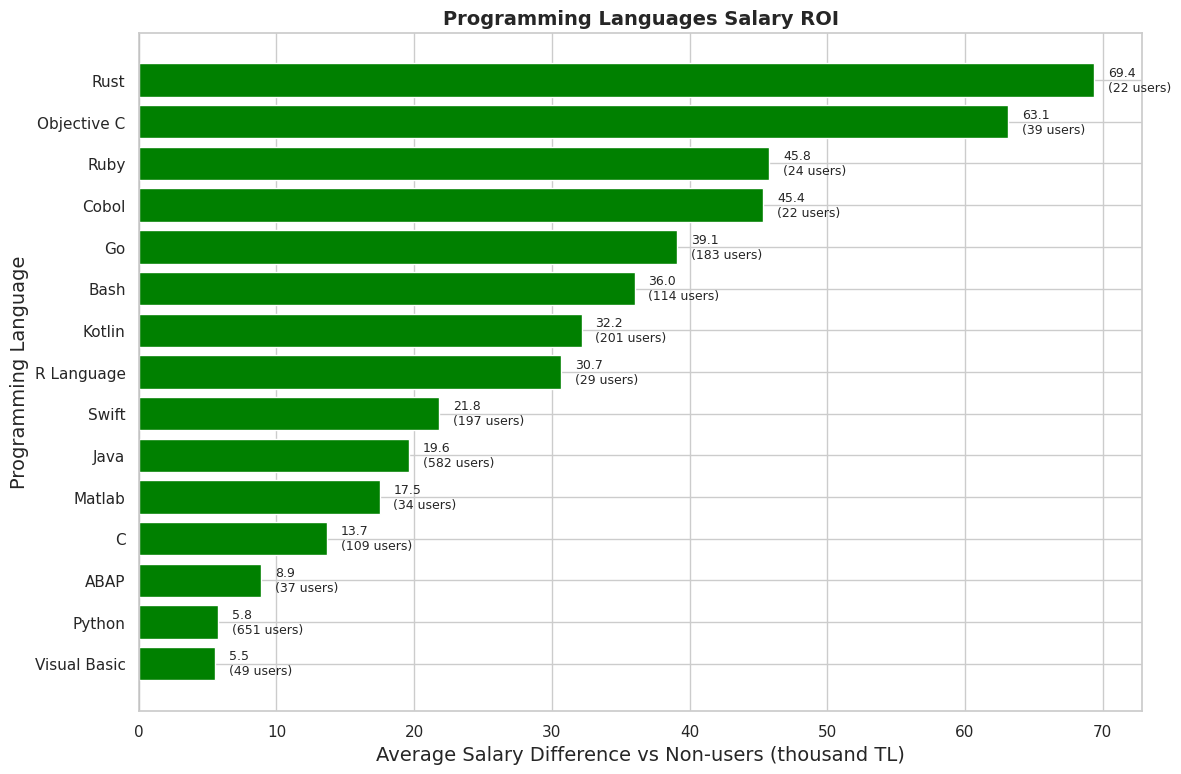

Programming Languages Salary ROI - Top 15 (Graph):


,Technology,ROI (thousand TL),User Count
0,Rust,69.4,22
1,Objective C,63.1,39
2,Ruby,45.8,24
3,Cobol,45.4,22
4,Go,39.1,183
5,Bash,36.0,114
6,Kotlin,32.2,201
7,R Language,30.7,29
8,Swift,21.8,197
9,Java,19.6,582



Programming Languages Salary ROI - All Technologies:


,Technology,ROI (thousand TL),User Count
0,Rust,69.4,22
1,Objective C,63.1,39
2,Ruby,45.8,24
3,Cobol,45.4,22
4,Go,39.1,183
5,Bash,36.0,114
6,Kotlin,32.2,201
7,R Language,30.7,29
8,Swift,21.8,197
9,Java,19.6,582


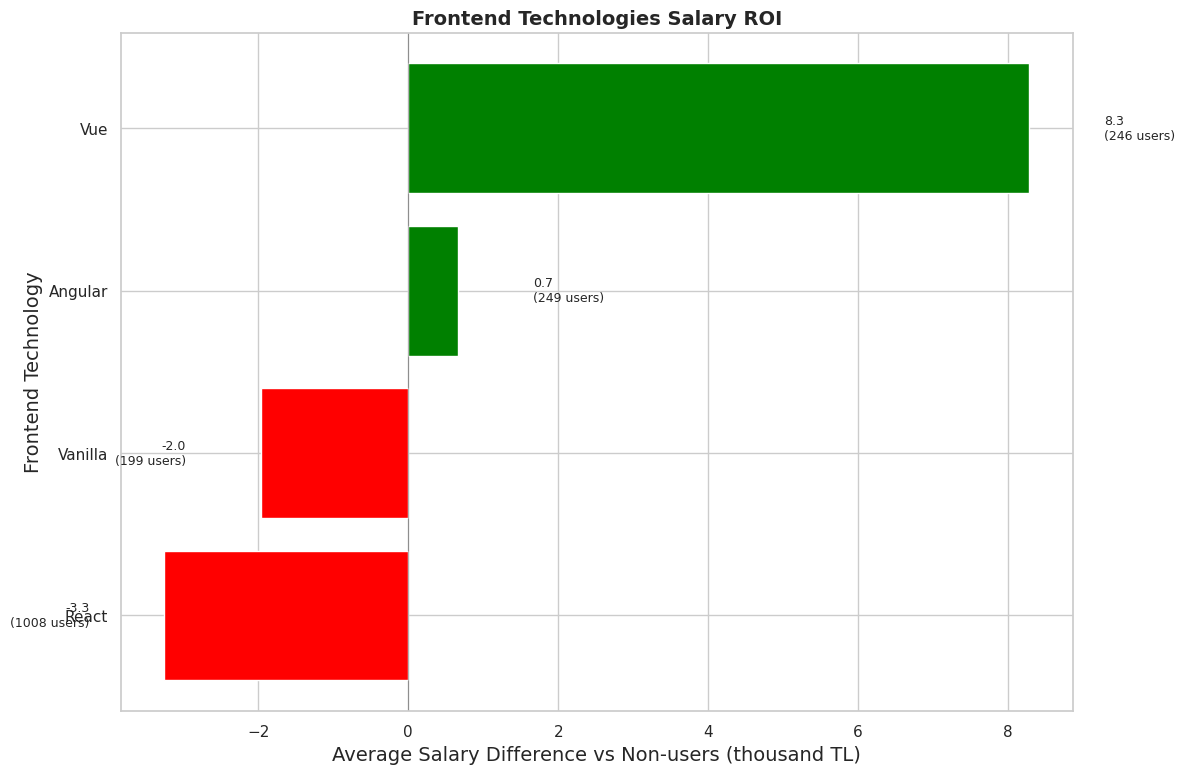

Frontend Technologies Salary ROI - Top 15 (Graph):


,Technology,ROI (thousand TL),User Count
0,Vue,8.3,246
1,Angular,0.7,249
2,Vanilla,-2.0,199
3,React,-3.3,1008


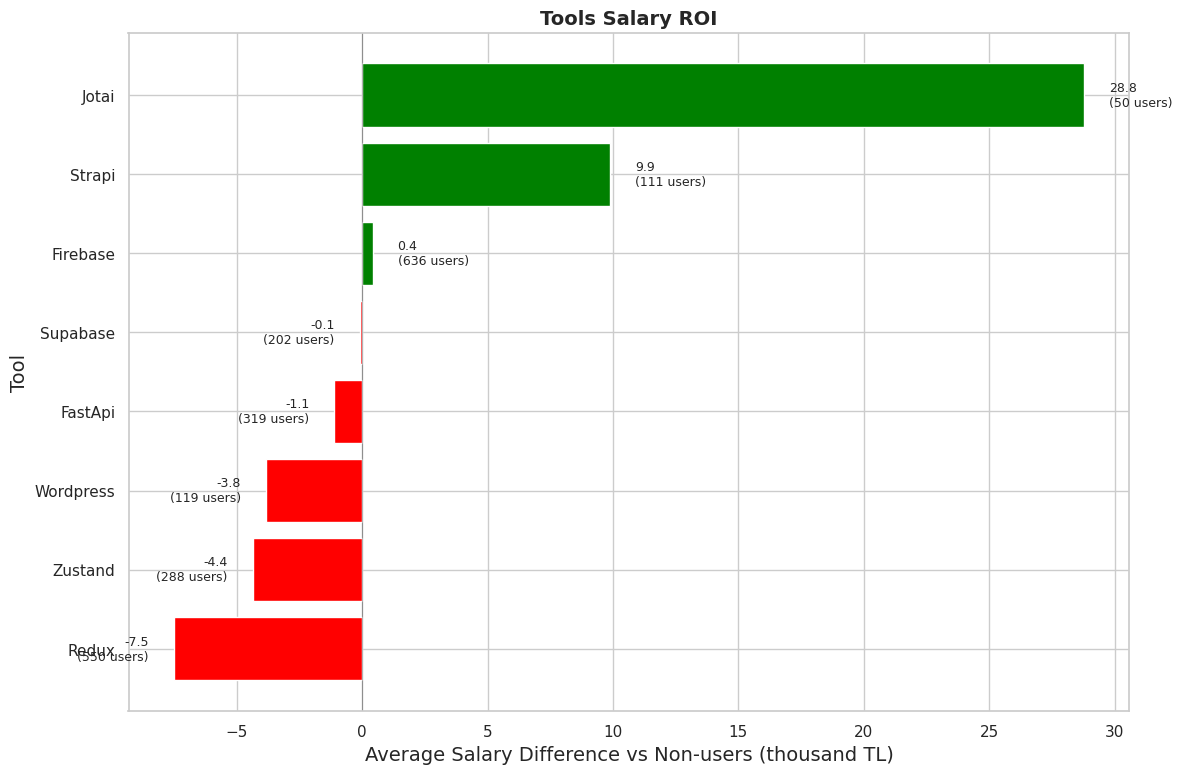

Tools Salary ROI - Top 15 (Graph):


,Technology,ROI (thousand TL),User Count
0,Jotai,28.8,50
1,Strapi,9.9,111
2,Firebase,0.4,636
3,Supabase,-0.1,202
4,FastApi,-1.1,319
5,Wordpress,-3.8,119
6,Zustand,-4.4,288
7,Redux,-7.5,550


In [78]:
def roi_for_prefix(prefix: str, exclude: set[str], out_name: str, title: str, ylabel: str, show_all_in_display=True):
    """Calculate and plot ROI for technologies with given prefix"""
    cols = [c for c in df.columns if c.startswith(prefix) and c not in exclude]
    rows = []
    
    for c in cols:
        users = df.loc[df[c] == 1, 'salary_numeric']
        non_users = df.loc[df[c] == 0, 'salary_numeric']
        if len(users) >= 10 and len(non_users) >= 10:
            roi = float(users.mean() - non_users.mean())
            rows.append((c.replace(prefix, '').replace('_', ' '), roi, int(len(users))))
    
    rows.sort(key=lambda x: x[1], reverse=True)
    if rows:
        names, rois, counts = zip(*rows[:15])
        
        plt.figure(figsize=(12, 8))
        colors = ['green' if r > 0 else 'red' for r in rois]
        bars = plt.barh(names, rois, color=colors)
        plt.gca().invert_yaxis()
        plt.title(title, fontsize=14, fontweight='bold')
        plt.xlabel('Average Salary Difference vs Non-users (thousand TL)', fontsize=14)
        plt.ylabel(ylabel, fontsize=14)
        
        for i, (bar, r, n) in enumerate(zip(bars, rois, counts)):
            xoff = 1 if r >= 0 else -1
            halign = 'left' if r >= 0 else 'right'
            plt.text(r + xoff, i, f'{r:.1f}\n({n} users)', va='center', ha=halign, fontsize=9)
        
        plt.axvline(0, color='black', lw=0.8, alpha=0.3)
        
        # Add note about excluded responses if applicable
        if 'Kullanmiyorum' in exclude or 'Hicbiri' in exclude:
            plt.figtext(0.5, 0.02, "Note: 'Kullanmiyorum' or 'Hicbiri' responses are excluded from the analysis.", 
                       ha='center', fontsize=10, style='italic', color='gray')
        
        plt.tight_layout()
        plt.subplots_adjust(bottom=0.1)  # Make room for the note
        plt.savefig(os.path.join(FIG_DIR, out_name), dpi=300, bbox_inches='tight')
        plt.show()
        
        # Display summary table for top 15
        roi_summary = pd.DataFrame({
            'Technology': names,
            'ROI (thousand TL)': rois,
            'User Count': counts
        }).round(1)
        print(f"{title} - Top 15 (Graph):")
        display(roi_summary)
        
        # Display all technologies if requested
        if show_all_in_display and len(rows) > 15:
            all_names, all_rois, all_counts = zip(*rows)
            all_roi_summary = pd.DataFrame({
                'Technology': all_names,
                'ROI (thousand TL)': all_rois,
                'User Count': all_counts
            }).round(1)
            print(f"\n{title} - All Technologies:")
            display(all_roi_summary)
        
        return roi_summary

# Programming Languages ROI
prog_roi = roi_for_prefix('programming_', {'programming_Hicbiri'}, 'barplot_programming_roi.png', 
                         'Programming Languages Salary ROI', 'Programming Language', True)

# Frontend Technologies ROI
frontend_roi = roi_for_prefix('frontend_', {'frontend_Kullanmiyorum'}, 'barplot_frontend_roi.png', 
                             'Frontend Technologies Salary ROI', 'Frontend Technology', False)

# Tools ROI
tools_roi = roi_for_prefix('tools_', {'tools_Kullanmiyorum'}, 'barplot_tools_roi.png', 
                          'Tools Salary ROI', 'Tool', False)

## Cinsiyete-Bazlı Teknoloji Kullanimi Analizi

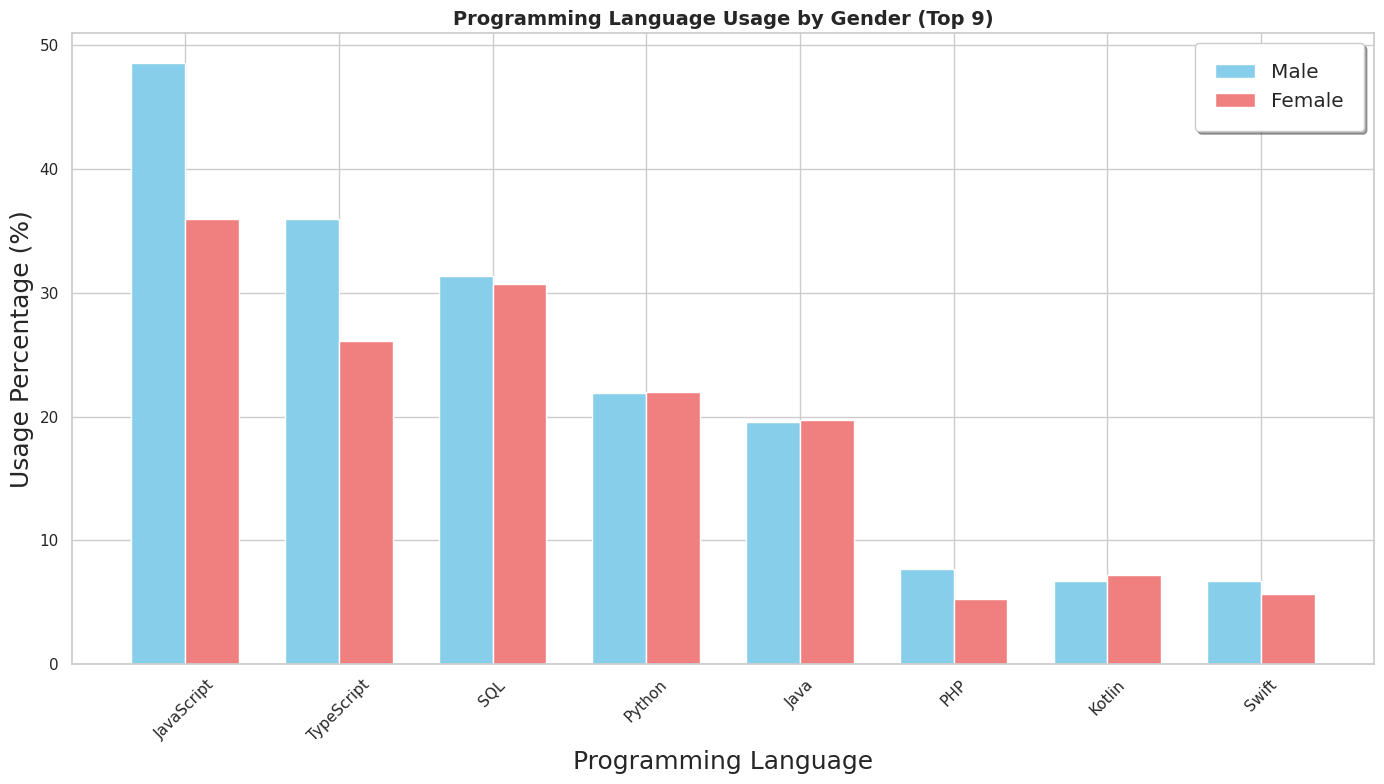

Programming Language Usage by Gender (Top 9 - Graph):


,Language,Male Usage (%),Female Usage (%),Difference (%)
0,JavaScript,48.5,36.0,12.6
1,TypeScript,36.0,26.1,9.8
2,SQL,31.4,30.7,0.7
3,Python,21.9,22.0,-0.0
4,Java,19.6,19.7,-0.1
5,PHP,7.7,5.3,2.3
6,Kotlin,6.7,7.2,-0.5
7,Swift,6.7,5.7,1.0



Programming Language Usage by Gender (All Languages):


,Language,Male Usage (%),Female Usage (%),Difference (%)
0,JavaScript,48.5,36.0,12.6
1,HTML CSS,40.9,32.6,8.3
2,TypeScript,36.0,26.1,9.8
3,SQL,31.4,30.7,0.7
4,Python,21.9,22.0,-0.0
5,Java,19.6,19.7,-0.1
6,Kotlin,6.7,7.2,-0.5
7,PHP,7.7,5.3,2.3
8,Swift,6.7,5.7,1.0
9,Go,6.4,3.8,2.6


In [80]:
# Programming languages by gender
lang_cols = [c for c in df.columns if c.startswith('programming_') and c != 'programming_Hicbiri']
if lang_cols:
    # Top 9 languages by overall usage
    lang_usage = []
    for col in lang_cols:
        usage = df[col].mean()
        lang_usage.append((col.replace('programming_', '').replace('_', ' '), usage))
    
    lang_usage.sort(key=lambda x: x[1], reverse=True)
    top_langs = [col.replace('programming_', '') for col, _ in lang_usage[:9]]
    
    # Create gender comparison for top languages
    gender_data = []
    for lang in top_langs:
        col = f'programming_{lang}'
        if col in df.columns:
            male_usage = df[df['gender'] == 0][col].mean() * 100
            female_usage = df[df['gender'] == 1][col].mean() * 100
            gender_data.append((lang.replace('_', ' '), male_usage, female_usage))
    
    if gender_data:
        langs, male_pct, female_pct = zip(*gender_data)
        x = np.arange(len(langs))
        width = 0.35
        
        plt.figure(figsize=(14, 8))
        plt.bar(x - width/2, male_pct, width, label='Male', color='skyblue')
        plt.bar(x + width/2, female_pct, width, label='Female', color='lightcoral')
        plt.xlabel('Programming Language', fontsize=18)
        plt.ylabel('Usage Percentage (%)', fontsize=18)
        plt.title('Programming Language Usage by Gender (Top 9)', fontsize=14, fontweight='bold')
        plt.xticks(x, langs, rotation=45)
        plt.legend(loc='upper right', frameon=True, fontsize="large", fancybox=True, shadow=True, borderpad=1)
        plt.tight_layout()
        plt.savefig(os.path.join(FIG_DIR, 'barplot_gender_programming.png'), dpi=300, bbox_inches='tight')
        plt.show()
        
        # Display summary table for top 9
        gender_prog_summary = pd.DataFrame({
            'Language': langs,
            'Male Usage (%)': male_pct,
            'Female Usage (%)': female_pct,
            'Difference (%)': [m - f for m, f in zip(male_pct, female_pct)]
        }).round(1)
        print("Programming Language Usage by Gender (Top 9 - Graph):")
        display(gender_prog_summary)
        
        # Display all languages
        all_gender_data = []
        for col in lang_cols:
            lang_name = col.replace('programming_', '').replace('_', ' ')
            male_usage = df[df['gender'] == 0][col].mean() * 100
            female_usage = df[df['gender'] == 1][col].mean() * 100
            all_gender_data.append((lang_name, male_usage, female_usage))
        
        all_gender_data.sort(key=lambda x: x[1] + x[2], reverse=True)  # Sort by total usage
        all_langs, all_male_pct, all_female_pct = zip(*all_gender_data)
        
        all_gender_prog_summary = pd.DataFrame({
            'Language': all_langs,
            'Male Usage (%)': all_male_pct,
            'Female Usage (%)': all_female_pct,
            'Difference (%)': [m - f for m, f in zip(all_male_pct, all_female_pct)]
        }).round(1)
        print("\nProgramming Language Usage by Gender (All Languages):")
        display(all_gender_prog_summary)

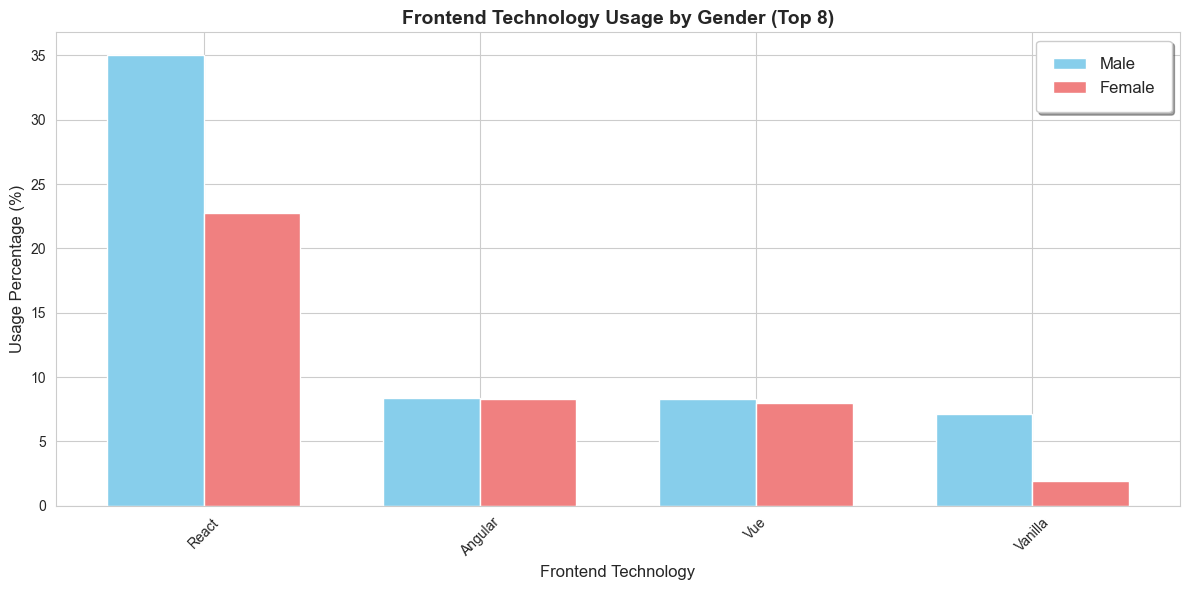

Frontend Technology Usage by Gender:


,Technology,Male Usage (%),Female Usage (%),Difference (%)
0,React,35.0,22.7,12.3
1,Angular,8.4,8.3,0.1
2,Vue,8.3,8.0,0.4
3,Vanilla,7.2,1.9,5.3


In [39]:
# Frontend technologies by gender
frontend_cols = [c for c in df.columns if c.startswith('frontend_') and c != 'frontend_Kullanmiyorum']
if frontend_cols:
    # Top 8 frontend technologies
    frontend_usage = []
    for col in frontend_cols:
        usage = df[col].mean()
        frontend_usage.append((col.replace('frontend_', '').replace('_', ' '), usage))
    
    frontend_usage.sort(key=lambda x: x[1], reverse=True)
    top_frontend = [col.replace('frontend_', '') for col, _ in frontend_usage[:8]]
    
    # Create gender comparison for top frontend technologies
    gender_data = []
    for tech in top_frontend:
        col = f'frontend_{tech}'
        if col in df.columns:
            male_usage = df[df['gender'] == 0][col].mean() * 100
            female_usage = df[df['gender'] == 1][col].mean() * 100
            gender_data.append((tech.replace('_', ' '), male_usage, female_usage))
    
    if gender_data:
        techs, male_pct, female_pct = zip(*gender_data)
        x = np.arange(len(techs))
        width = 0.35
        
        plt.figure(figsize=(12, 6))
        plt.bar(x - width/2, male_pct, width, label='Male', color='skyblue')
        plt.bar(x + width/2, female_pct, width, label='Female', color='lightcoral')
        plt.xlabel('Frontend Technology', fontsize=12)
        plt.ylabel('Usage Percentage (%)', fontsize=12)
        plt.title('Frontend Technology Usage by Gender (Top 8)', fontsize=14, fontweight='bold')
        plt.xticks(x, techs, rotation=45)
        plt.legend(loc='upper right', frameon=True, fontsize="large", fancybox=True, shadow=True, borderpad=1)
        plt.tight_layout()
        plt.savefig(os.path.join(FIG_DIR, 'barplot_gender_frontend.png'), dpi=300, bbox_inches='tight')
        plt.show()
        
        # Display summary table
        gender_frontend_summary = pd.DataFrame({
            'Technology': techs,
            'Male Usage (%)': male_pct,
            'Female Usage (%)': female_pct,
            'Difference (%)': [m - f for m, f in zip(male_pct, female_pct)]
        }).round(1)
        print("Frontend Technology Usage by Gender:")
        display(gender_frontend_summary)

## Scatter Plot: Kariyer Zaman Çizelgesi Analizi

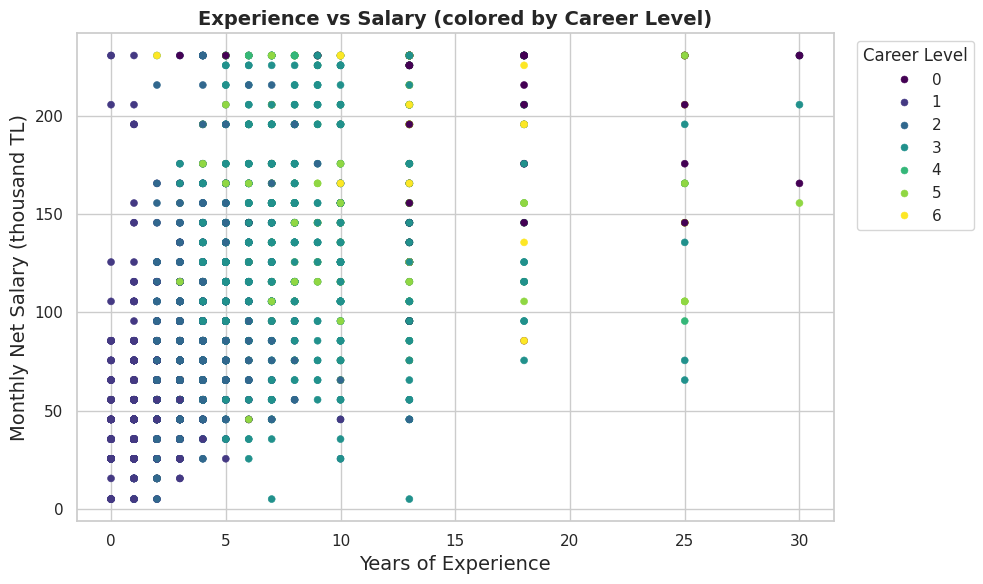

Correlation between experience and salary: 0.623

Salary Statistics by Experience Range:


,Count,Mean Salary,Std Dev
experience_range,,,
0-2,699,57.1,30.4
3-5,1271,91.6,38.6
6-10,605,137.8,49.8
11-15,188,166.4,57.7
15+,85,178.1,51.7


In [83]:
# Experience vs Salary scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='experience_years', y='salary_numeric', hue='seniority_level_ic', 
                palette='viridis', s=25, edgecolor=None)
plt.title('Experience vs Salary (colored by Career Level)', fontsize=14, fontweight='bold')
plt.xlabel('Years of Experience', fontsize=14)
plt.ylabel('Monthly Net Salary (thousand TL)', fontsize=14)
plt.legend(title='Career Level', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'scatter_experience_salary.png'), dpi=300, bbox_inches='tight')
plt.show()

# Calculate correlation
correlation = df['experience_years'].corr(df['salary_numeric'])
print(f"Correlation between experience and salary: {correlation:.3f}")

# Display summary statistics by experience ranges
df['experience_range'] = pd.cut(df['experience_years'], bins=[0, 2, 5, 10, 15, 50], 
                                labels=['0-2', '3-5', '6-10', '11-15', '15+'])
exp_summary = df.groupby('experience_range', observed=True)['salary_numeric'].agg(['count', 'mean', 'std']).round(1)
exp_summary.columns = ['Count', 'Mean Salary', 'Std Dev']
print("\nSalary Statistics by Experience Range:")
display(exp_summary)

## Temel Görselleştirmelerin Özeti

In [84]:
print("Core Visualizations Generated:")
print("1. Boxplots:")
print("   - Salary by Career Level")
print("   - Salary by Management Level")
print("   - Salary by Work Mode")
print("   - Salary by Company Location")
print("   - Salary by Gender")
print("   - Salary by Employment Type")
print("\n2. Bar Plots:")
print("   - Average Salary by Role (Top 15)")
print("   - Programming Languages ROI")
print("   - Frontend Technologies ROI")
print("   - Tools ROI")
print("   - Gender-based Technology Usage")
print("\n3. Scatter Plot:")
print("   - Experience vs Salary (Career Timeline)")
print(f"\nTotal visualizations created: 12")
print(f"All files saved to: {FIG_DIR}")

Core Visualizations Generated:
1. Boxplots:
   - Salary by Career Level
   - Salary by Management Level
   - Salary by Work Mode
   - Salary by Company Location
   - Salary by Gender
   - Salary by Employment Type

2. Bar Plots:
   - Average Salary by Role (Top 15)
   - Programming Languages ROI
   - Frontend Technologies ROI
   - Tools ROI
   - Gender-based Technology Usage

3. Scatter Plot:
   - Experience vs Salary (Career Timeline)

Total visualizations created: 12
All files saved to: ../figures
